# Problem 4 - Fooling Convolutional Neural Networks

In [2]:
from __future__ import print_function, division
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import torchvision
import shutil
import os
import pandas
import torch
import numpy as np
import time
import copy
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import normalize as norm
import imutils
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.get_device_name(0)

'Quadro RTX 5000 with Max-Q Design'

In [6]:
# Using GPU device
gpu_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Part 1

### Load model

In [7]:
# Load the pre trained model
res_152_model = models.resnet152(pretrained = True)
_ = res_152_model.eval()

In [8]:
# Load all the resnet 1000 labels
with open("imagenet_class_index.json") as f:
    resnet_labels = json.load(f)

### Load Image function to load Pepper

In [9]:
def load_image(link):
    image = cv2.imread(link)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create pipeline to preprocess the image, size and turn into pytorch tensor
    pre_process = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((224, 224)), transforms.ToTensor()])
    
    # Transform
    image_ts = pre_process(image)
    # Put into batch to run in the model
    image_batch = torch.unsqueeze(image_ts, 0)
    
    return image_batch

In [10]:
pep_batch = load_image("peppers.jpg")

#### The prediction of original image

In [11]:
# Print the top 3
def top_3(image, link, version):
    # Predict with model
    output_res_152 = res_152_model(image)
    
    _, indexes_res_152 = torch.topk(output_res_152, 3)
    p_res_152 = torch.nn.functional.softmax(output_res_152, dim = 1)[0] * 100
    final_p_res_152 = []
    for index in indexes_res_152[0]:
        final_p_res_152.append([index.item(), resnet_labels[str(int(index))][1], p_res_152[int(index)].item()])
    df_res_152 = pd.DataFrame(final_p_res_152, columns = ['ID', 'predicted categories', '% probabilities'])
    print("--- " + " predictions of " + version + " " + link + " ---")
    print(df_res_152)

In [12]:
top_3(pep_batch, "peppers.jpg", "Original")

---  predictions of Original peppers.jpg ---
    ID predicted categories  % probabilities
0  945          bell_pepper        80.637512
1  680               nipple         5.370522
2  987                 corn         2.232531


### Fooling the model using pepper image recognize as rocket

In [13]:
# From this label
resnet_labels['945']

['n07720875', 'bell_pepper']

In [14]:
# Want this label
resnet_labels['812']

['n04266014', 'space_shuttle']

In [18]:
def fool(tensor_img, true_label, stage, eps):
    img_variable = Variable(tensor_img, requires_grad = True)
    output = res_152_model.forward(img_variable)
    target = Variable(torch.LongTensor([true_label]), requires_grad=False)
    loss = torch.nn.CrossEntropyLoss()
    print(output.shape, target.shape)
    loss_cal = loss(output, target)
    loss_cal.backward(retain_graph=True)
    x_grad = torch.sign(img_variable.grad.data)
    if stage == "+":
        noise = x_grad
    else:
        noise = - x_grad
    tensor_img = img_variable.data + eps * noise
    
    output_adv = res_152_model.forward(Variable(tensor_img))
    pred = torch.max(output_adv.data, 1)[1][0].item()
    x_adv_pred = resnet_labels[str(pred)]
    op_adv_probs = torch.nn.functional.softmax(output_adv, dim=1)    
    adv_pred_prob = (torch.max(op_adv_probs.data, 1)[0][0]).item()
    return tensor_img, pred, adv_pred_prob, noise

In [19]:
def fool_run(image_batch, true_label, target_id):
    epsilon = 0.003
    cur_image, cur_label, prob, noise_img = fool(image_batch, true_label, "+", epsilon)
    cur_image, cur_label, prob, new_noise = fool(cur_image, target_id, "-", epsilon)
    noise_img += new_noise
    while cur_label != target_id:
        cur_image, cur_label, prob, new_noise = fool(cur_image, cur_label, "+", epsilon)
        noise_img += new_noise
        cur_image, cur_label, prob, new_noise = fool(cur_image, target_id, "-", epsilon)
        noise_img += new_noise
    
    # Add noise image to original image
    new_image = image_batch + epsilon * noise_img
    
    return noise_img, new_image

In [20]:
pep_noise_img, pep_new_image = fool_run(pep_batch, 945, 812)

torch.Size([1, 1000]) torch.Size([1])
torch.Size([1, 1000]) torch.Size([1])


KeyboardInterrupt: 

In [ ]:
# Display the images in rows and columns
def display_noise_new(original_images, noise_images, new_images, links):
    image_num = len(original_images)
    
    std_correction = np.asarray([1.0, 1.0, 1.0]).reshape(3, 1, 1)
    mean_correction = np.asarray([0, 0, 0]).reshape(3, 1, 1)
    
    fig = plt.figure(figsize=(14, 14))
    
    for i in range(image_num):
        # Display original image
        display_ori_image = np.multiply(original_images[i].numpy(), std_correction) + mean_correction
        axes = fig.add_subplot(image_num, 3, i * 3 + 1)
        _ = plt.imshow((torchvision.utils.make_grid(torch.from_numpy(display_ori_image)).permute(1, 2, 0) * 255).numpy().astype('uint8'))
        _ = plt.title("Original image -- " + links[i])

        # Display noise image without epsilon
        axes = fig.add_subplot(image_num, 3, i * 3 + 2)
        _ = plt.imshow((torchvision.utils.make_grid(noise_images[i]).permute(1, 2, 0) * 255).numpy().astype('uint8'))
        _ = plt.title("Noise image -- " + links[i])

        # Print new image made to fool the resnet   
        axes = fig.add_subplot(image_num, 3, i * 3 + 3)
        display_new_image = np.multiply(new_images[i].numpy(), std_correction) + mean_correction
        _ = plt.imshow((torchvision.utils.make_grid(torch.from_numpy(new_images[i].numpy())).permute(1, 2, 0)).numpy())
        _ = plt.title("New image -- " + links[i])
        
        top_3(original_images[i], links[i], "Original")
        top_3(new_images[i], links[i], "New")
        
        print("===========================================")

In [ ]:
display_noise_new([pep_batch], [pep_noise_img], [pep_new_image], ["peppers.jpg"])

Now I have made the pepper into rocket, I will make a main function to do the other 3 images and show them together

### The other three images

In [19]:
banana_batch = load_image("banana.jpg")
banana_noise_img, banana_new_image = fool_run(banana_batch, 954, 1)

In [20]:
watch_batch = load_image("watch.jpg")
watch_noise_img, watch_new_image = fool_run(watch_batch, 531, 1)

In [21]:
chair_batch = load_image("chair.jpg")
chair_noise_img, chair_new_image = fool_run(chair_batch, 559, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---  predictions of Original pepper.jpg ---
    ID predicted categories  % probabilities
0  945          bell_pepper        80.637512
1  680               nipple         5.370522
2  987                 corn         2.232531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---  predictions of New pepper.jpg ---
    ID predicted categories  % probabilities
0  812        space_shuttle        45.378967
1  611        jigsaw_puzzle         5.187850
2  417              balloon         2.756755
---  predictions of Original banana.jpg ---
    ID predicted categories  % probabilities
0  954               banana        98.904686
1  473           can_opener         0.124988
2  110             flatworm         0.107211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---  predictions of New banana.jpg ---
    ID predicted categories  % probabilities
0    1             goldfish        23.055456
1  883                 vase         3.249339
2  644           matchstick         3.130264
---  predictions of Original watch.jpg ---
    ID predicted categories  % probabilities
0  531        digital_watch        95.039299
1  826            stopwatch         4.320557
2  530        digital_clock         0.444843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---  predictions of New watch.jpg ---
    ID predicted categories  % probabilities
0    1             goldfish        11.286273
1   36             terrapin         3.848738
2  473           can_opener         3.261532
---  predictions of Original chair.jpg ---
    ID predicted categories  % probabilities
0  559        folding_chair        91.090027
1  765        rocking_chair         8.661638
2  532         dining_table         0.094648
---  predictions of New chair.jpg ---
    ID predicted categories  % probabilities
0    1             goldfish         5.089085
1  765        rocking_chair         2.354373
2  559        folding_chair         2.216512


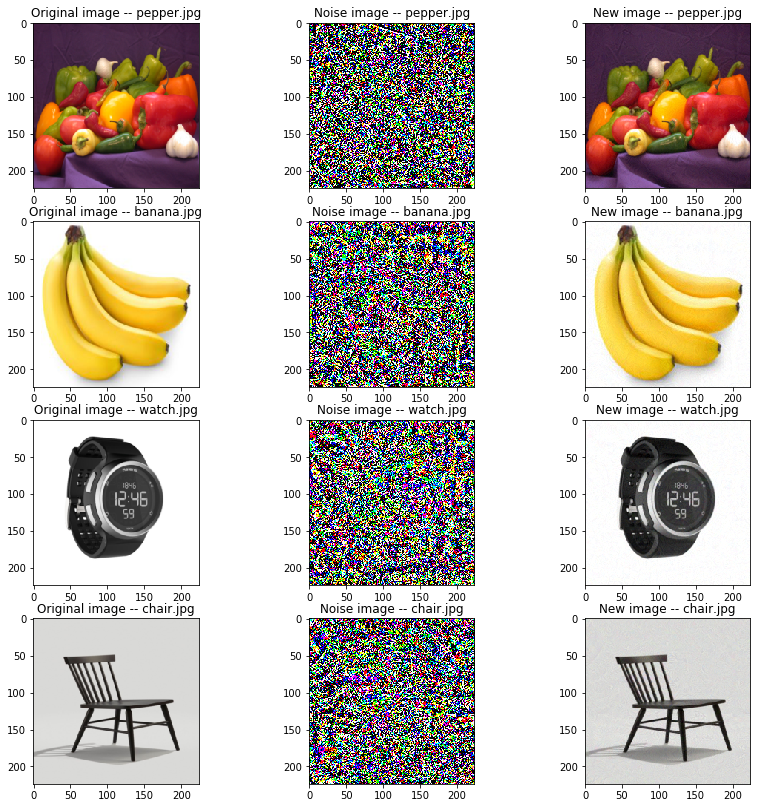

In [22]:
display_noise_new([pep_batch, banana_batch, watch_batch, chair_batch],
                  [pep_noise_img, banana_noise_img, watch_noise_img, chair_noise_img],
                  [pep_new_image, banana_new_image, watch_new_image, chair_new_image],
                  ["pepper.jpg", "banana.jpg", "watch.jpg", "chair.jpg"])

Made them all into goldfish

## Part 2

In [23]:
# Display the images in rows and columns
def display_transformation(fool_images, flip_images, crop_images, rotate_images, gray_images, links):
    image_num = len(fool_images)    
    fig = plt.figure(figsize=(14, 14))
    
    for i in range(image_num):
        # Display original fool image
        axes = fig.add_subplot(image_num, 5, i * 5 + 1)
        _ = plt.imshow(torchvision.utils.make_grid(fool_images[i]).permute(1, 2, 0))
        _ = plt.title("Fool image -- " + links[i])

        # Display flip image
        axes = fig.add_subplot(image_num, 5, i * 5 + 2)
        _ = plt.imshow(torchvision.utils.make_grid(flip_images[i]).permute(1, 2, 0))
        _ = plt.title("Flip image -- " + links[i])

        # Display the crop image
        axes = fig.add_subplot(image_num, 5, i * 5 + 3)
        _ = plt.imshow(torchvision.utils.make_grid(crop_images[i]).permute(1, 2, 0))
        _ = plt.title("Crop image -- " + links[i])
        
        # Display rotated image
        axes = fig.add_subplot(image_num, 5, i * 5 + 4)
        _ = plt.imshow(torchvision.utils.make_grid(rotate_images[i]).permute(1, 2, 0))
        _ = plt.title("Rotate image -- " + links[i])
        
        # Display gray and replicate image
        axes = fig.add_subplot(image_num, 5, i * 5 + 5)
        _ = plt.imshow(torchvision.utils.make_grid(gray_images[i]).permute(1, 2, 0))
        _ = plt.title("Gray image -- " + links[i])
        
        top_3(fool_images[i], links[i], "Fool")
        top_3(flip_images[i], links[i], "Flip")
        top_3(crop_images[i], links[i], "Crop")
        top_3(rotate_images[i], links[i], "Rotate")
        top_3(gray_images[i], links[i], "Gray")
        
        print("===========================================")

### Flip

In [24]:
pep_flip = torch.flip(pep_new_image, (2, 3))

### Crop

In [25]:
pep_crop = pep_new_image[:,:,22:201, 22:201]

### Rotate

In [26]:
def image_rotate(image):
    image = (torchvision.utils.make_grid(torch.from_numpy(image.numpy())).permute(1, 2, 0)).numpy()
    image = imutils.rotate_bound(image, 30)
    # Create pipeline to preprocess the image, size and turn into pytorch tensor
    pre_process = transforms.Compose([ transforms.ToTensor()])
    
    # Transform
    image_ts = pre_process(image)
    # Put into batch to run in the model
    image_batch = torch.unsqueeze(image_ts, 0)
    return image_batch

In [27]:
pep_rotate = image_rotate(pep_new_image)

### To gray and replicate 3 channels

In [28]:
def to_gray_rep(image):
    image = (torchvision.utils.make_grid(torch.from_numpy(image.numpy())).permute(1, 2, 0)).numpy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.stack((image,) * 3, axis=-1)
    # Create pipeline to preprocess the image, size and turn into pytorch tensor
    pre_process = transforms.Compose([ transforms.ToTensor()])
    
    # Transform
    image_ts = pre_process(image)
    # Put into batch to run in the model
    image_batch = torch.unsqueeze(image_ts, 0)
    return image_batch

In [29]:
pep_gray = to_gray_rep(pep_new_image)

### Display the results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---  predictions of Fool pepper.jpg ---
    ID predicted categories  % probabilities
0  812        space_shuttle        45.378967
1  611        jigsaw_puzzle         5.187850
2  417              balloon         2.756755
---  predictions of Flip pepper.jpg ---
    ID predicted categories  % probabilities
0  435              bathtub         6.916928
1  876                  tub         5.772854
2  804       soap_dispenser         3.934428
---  predictions of Crop pepper.jpg ---
    ID predicted categories  % probabilities
0  868                 tray        10.596503
1  945          bell_pepper        10.267315
2  417              balloon         5.906263
---  predictions of Rotate pepper.jpg ---
    ID predicted categories  % probabilities
0  948         Granny_Smith        17.521166
1  945          bell_pepper        11.765151
2  435              bathtub         6.212464
---  predictions of Gray pepper.jpg ---
    ID predicted categories  % probabilities
0  107            jellyfish      

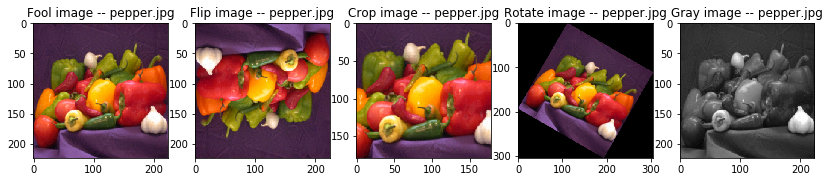

In [30]:
display_transformation([pep_new_image], [pep_flip], [pep_crop], [pep_rotate], [pep_gray], ["pepper.jpg"])

### Do the other three images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---  predictions of Fool banana.jpg ---
    ID predicted categories  % probabilities
0    1             goldfish        23.055456
1  883                 vase         3.249339
2  644           matchstick         3.130264
---  predictions of Flip banana.jpg ---
    ID predicted categories  % probabilities
0  954               banana        28.146786
1  584           hair_slide        12.742746
2  939             zucchini         4.449924
---  predictions of Crop banana.jpg ---
    ID predicted categories  % probabilities
0  794       shower_curtain        13.428257
1  954               banana         8.985217
2  117   chambered_nautilus         5.561769
---  predictions of Rotate banana.jpg ---
    ID predicted categories  % probabilities
0  954               banana        53.304314
1  942     butternut_squash         4.478898
2  948         Granny_Smith         2.827502
---  predictions of Gray banana.jpg ---
    ID predicted categories  % probabilities
0  794       shower_curtain      

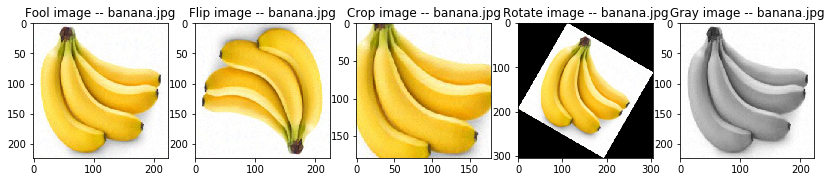

In [31]:
banana_flip = torch.flip(banana_new_image, (2, 3))
banana_crop = banana_new_image[:,:,22:201, 22:201]
banana_rotate = image_rotate(banana_new_image)
banana_gray = to_gray_rep(banana_new_image)

display_transformation([banana_new_image], [banana_flip], [banana_crop], [banana_rotate], [banana_gray], ["banana.jpg"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---  predictions of Fool watch.jpg ---
    ID predicted categories  % probabilities
0    1             goldfish        11.286273
1   36             terrapin         3.848738
2  473           can_opener         3.261532
---  predictions of Flip watch.jpg ---
    ID predicted categories  % probabilities
0  531        digital_watch        46.094330
1  826            stopwatch        23.447561
2  530        digital_clock        15.941308
---  predictions of Crop watch.jpg ---
    ID predicted categories  % probabilities
0  826            stopwatch        31.327736
1  531        digital_watch        23.700247
2  530        digital_clock        12.256587
---  predictions of Rotate watch.jpg ---
    ID predicted categories  % probabilities
0  826            stopwatch        23.467844
1  531        digital_watch        16.216324
2  507     combination_lock         9.414369
---  predictions of Gray watch.jpg ---
    ID predicted categories  % probabilities
0  531        digital_watch         8.

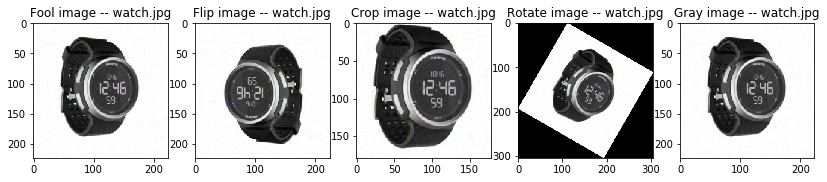

In [32]:
watch_flip = torch.flip(watch_new_image, (2, 3))
watch_crop = watch_new_image[:,:,22:201, 22:201]
watch_rotate = image_rotate(watch_new_image)
watch_gray = to_gray_rep(watch_new_image)

display_transformation([watch_new_image], [watch_flip], [watch_crop], [watch_rotate], [watch_gray], ["watch.jpg"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---  predictions of Fool chair.jpg ---
    ID predicted categories  % probabilities
0    1             goldfish         5.089085
1  765        rocking_chair         2.354373
2  559        folding_chair         2.216512
---  predictions of Flip chair.jpg ---
    ID predicted categories  % probabilities
0  559        folding_chair        66.600594
1  729           plate_rack         6.668369
2  765        rocking_chair         3.913774
---  predictions of Crop chair.jpg ---
    ID predicted categories  % probabilities
0  559        folding_chair        50.508766
1  765        rocking_chair        47.268837
2  532         dining_table         0.880183
---  predictions of Rotate chair.jpg ---
    ID predicted categories  % probabilities
0  559        folding_chair        64.583878
1  549             envelope        20.275911
2  644           matchstick         1.338506
---  predictions of Gray chair.jpg ---
    ID predicted categories  % probabilities
0  559        folding_chair         6.

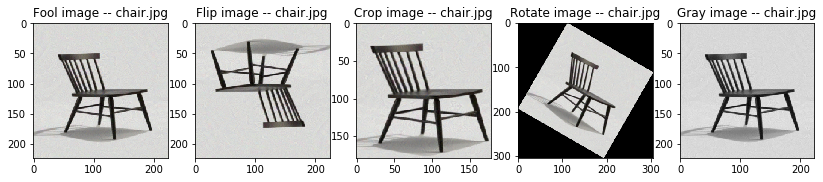

In [33]:
chair_flip = torch.flip(chair_new_image, (2, 3))
chair_crop = chair_new_image[:,:,22:201, 22:201]
chair_rotate = image_rotate(chair_new_image)
chair_gray = to_gray_rep(chair_new_image)

display_transformation([chair_new_image], [chair_flip], [chair_crop], [chair_rotate], [chair_gray], ["chair.jpg"])